In [198]:
import os
import json
import tqdm
import random
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

In [199]:
images_path = "./standardised_images_2/task_wlt_350_210926_p_2111131_wlt_350_210926__020 p_2111131.jpg-2023_02_10_07_43_07-coco 1.0/images/"
annotations_path = "./standardised_images_2/task_wlt_350_210926_p_2111131_wlt_350_210926__020 p_2111131.jpg-2023_02_10_07_43_07-coco 1.0/annotations/"
instances_default = json.loads(open(annotations_path + "instances_default_new.json").read())
images = instances_default["images"]
annotations = instances_default["annotations"]
categories = instances_default["categories"]

In [200]:
len(os.listdir(images_path))

1098922

In [201]:
images[5000], annotations[0]

({'id': '1.9050.30',
  'file_name': 'WLT_350_210926 P_2111131 WLT_350_210926__004 P_2111131.JPG_9050_30.jpg',
  'width': 200,
  'height': 200,
  'old_id': 1},
 {'id': '13.11050.30',
  'image_id': '1.11050.30',
  'old_image_id': 1,
  'category_id': 2,
  'bbox': [133.73999999999978,
   114.66999999999999,
   61.68000000000029,
   92.51000000000002],
  'area': 5706.0168000000285,
  'iscrowd': 0,
  'inter_percentage': 0.922386768997946})

In [202]:
categories

[{'id': 1, 'name': 'strong parabola', 'supercategory': ''},
 {'id': 2, 'name': 'weak parabola', 'supercategory': ''},
 {'id': 3, 'name': 'strong reflector', 'supercategory': ''},
 {'id': 4, 'name': 'weak reflector', 'supercategory': ''},
 {'id': 5, 'name': 'other', 'supercategory': ''}]

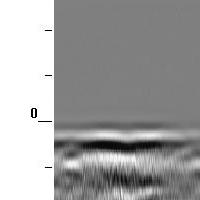

In [203]:
# use PIL to draw the bounding boxes on a sample image
img_new = Image.open(images_path + images[1]["file_name"])
draw = ImageDraw.Draw(img_new)
for annotation in annotations:
    if annotation["image_id"] != images[1]["id"]:
        continue
    bbox = [annotation["bbox"][0], annotation["bbox"][1], annotation["bbox"][0] + annotation["bbox"][2], annotation["bbox"][1] + annotation["bbox"][3]]
    draw.rectangle(bbox, outline="red")
img_new

In [204]:
class GPRDatasetClassification(torch.utils.data.Dataset):
    def __init__(self, data_dir, train=True, test=False):
        self.data_dir = data_dir
        self.images_dir = os.path.join(data_dir, 'images')
        self.annotations_dir = os.path.join(data_dir, 'annotations')

        instances_default = json.load(open(os.path.join(self.annotations_dir, 'instances_default_new.json')))
        self.images = instances_default["images"]
        self.annotations = instances_default["annotations"]
        self.categories = instances_default["categories"]
        self.balanced_images = self._balance_items(train=train, test=test)
    
    def _balance_items(self, train=True, test=False):
        for image_ in self.images:
            for annotation in self.annotations:
                if annotation["image_id"] == image_["id"]:
                    if annotation["category_id"] in [1,2]:
                        image_["has_required_annotations"] = True
                        break
            # else:
            #     image_["has_required_annotations"] = False
        
        balanced_images = []
        pos_samples = []
        neg_samples = []
        for image_ in self.images:
            if image_.get("has_required_annotations"):
                pos_samples.append(image_)
            else:
                neg_samples.append(image_)

        selected_neg_samples = [random.choice(neg_samples) for i in range(len(pos_samples))]
        balanced_images = pos_samples + selected_neg_samples
        print(f"Balanced dataset: {len(balanced_images)} images, {len(pos_samples)} positive samples, {len(selected_neg_samples)} negative samples")
        balanced_images_train, balanced_images_test = train_test_split(balanced_images, test_size=0.2, random_state=42)
        if train:
            print(f"Training dataset: {len(balanced_images_train)} images")
            return balanced_images_train
        elif test:
            print(f"Testing dataset: {len(balanced_images_test)} images")
            return balanced_images_test
        else:
            return balanced_images

    
    def __getitem__(self, idx):
        # img = Image.open(os.path.join(self.images_dir, self.images[idx]["file_name"])).convert("L")
        img = Image.open(os.path.join(self.images_dir, self.balanced_images[idx]["file_name"])).convert("L")
        # img = img.resize((100, 100))
        t = []
        t.append(transforms.PILToTensor())
        t.append(transforms.ConvertImageDtype(torch.float))
        img = transforms.Compose(t)(img)
        for annotation in self.annotations:
            if annotation["image_id"] != self.balanced_images[idx]["id"]:
                continue
            bbox = [annotation["bbox"][0], annotation["bbox"][1],
                     annotation["bbox"][0] + annotation["bbox"][2],
                       annotation["bbox"][1] + annotation["bbox"][3]]
            label = annotation["category_id"]
            if label in [1,2]:
                return img, torch.tensor(1)
            else:
                return img, torch.tensor(0)
        else:
            return img, torch.tensor(0)
    
    def __len__(self):
        return len(self.balanced_images)

In [205]:
x2, x1 = train_test_split([1,2,3,4,5,6], test_size=0.33, random_state=42)

In [206]:
x1

[1, 2]

In [ ]:
standard_path = "./standardised_images_2/task_wlt_350_210926_p_2111131_wlt_350_210926__020 p_2111131.jpg-2023_02_10_07_43_07-coco 1.0/"
gprdataset = GPRDatasetClassification(standard_path, train=False, test=False)
# create a dataloader
gpr_classification_dataloader = torch.utils.data.DataLoader(gprdataset, batch_size=16, shuffle=True)

In [211]:
standard_path = "./standardised_images_2/task_wlt_350_210926_p_2111131_wlt_350_210926__020 p_2111131.jpg-2023_02_10_07_43_07-coco 1.0/"
gprdataset_train = GPRDatasetClassification(standard_path, train=True, test=False)
gprdataset_test = GPRDatasetClassification(standard_path, train=False, test=True)
# create a dataloader
gpr_classification_dataloader_train = torch.utils.data.DataLoader(gprdataset_train, batch_size=16, shuffle=True)
gpr_classification_dataloader_test = torch.utils.data.DataLoader(gprdataset_test, batch_size=16, shuffle=True)

Balanced dataset: 12768 images, 6384 positive samples, 6384 negative samples
Training dataset: 10214 images


In [ ]:
len(gpr_classification_dataloader), len(gpr_classification_dataloader_train), len(gpr_classification_dataloader_test)

(798, 639, 160)

In [210]:
for i in gpr_classification_dataloader:
    print(i[0].shape)
    break

NameError: name 'gpr_classification_dataloader' is not defined

In [ ]:
# count_pos = 0
# for i in gpr_classification_dataloader:
#     if i[1].item() == 1:
#         count_pos += 1

# count_pos

In [ ]:
import torchvision

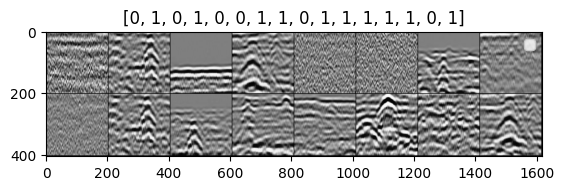

    0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img, title):
    # img = img / 2 + 0.5     # unnormalize
    # npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.legend({0: "No Parabola", 1: "Parabola"})
    plt.show()


# get some random training images
dataiter = iter(gpr_classification_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images), title=[x.item() for x in labels])
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(1)))

In [ ]:
classes

{0: 'no_para', 1: 'para'}

In [ ]:
len(gpr_classification_dataloader)

798

In [ ]:
class SelfAttention(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim
        # self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out, attention


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.attn = SelfAttention(16)
        self.fc1 = nn.Linear(35344, 120) # 150544 = 16 * 5 * 5, 7744, 35344
        # self.fc2 = nn.Linear(15000, 1500)
        # self.fc3 = nn.Linear(1500, 120) 
        self.fc4 = nn.Linear(120, 84)
        self.fc5 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x, _ = self.attn(x)
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        # x = self.fc3(x)
        return x, _


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/cnn_gpr_classification_1')

In [ ]:
writer.add_graph(net, images)
writer.close()

In [17]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(gpr_classification_dataloader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, attn = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,     1] loss: 0.000
[1,    51] loss: 0.017
[1,   101] loss: 0.017
[1,   151] loss: 0.016
[1,   201] loss: 0.013
[1,   251] loss: 0.011
[1,   301] loss: 0.011
[1,   351] loss: 0.009
[1,   401] loss: 0.009
[1,   451] loss: 0.009
[1,   501] loss: 0.010
[1,   551] loss: 0.009
[1,   601] loss: 0.009
[2,     1] loss: 0.000
[2,    51] loss: 0.008
[2,   101] loss: 0.007
[2,   151] loss: 0.009
[2,   201] loss: 0.009
[2,   251] loss: 0.008
[2,   301] loss: 0.009
[2,   351] loss: 0.008
[2,   401] loss: 0.008
[2,   451] loss: 0.009
[2,   501] loss: 0.009
[2,   551] loss: 0.008
[2,   601] loss: 0.008
Finished Training


In [54]:
attn[0]

tensor([[[0.4941, 0.4941, 0.4941,  ..., 0.4902, 0.4902, 0.4902],
         [0.4941, 0.4941, 0.4941,  ..., 0.4902, 0.4902, 0.4902],
         [0.4941, 0.4941, 0.4941,  ..., 0.4941, 0.4902, 0.4902],
         ...,
         [0.6353, 0.6353, 0.4627,  ..., 0.6314, 0.7765, 0.5647],
         [0.6196, 0.6314, 0.4706,  ..., 0.6314, 0.7843, 0.6118],
         [0.6118, 0.6314, 0.4824,  ..., 0.6157, 0.7804, 0.6431]]])

In [18]:
# prepare to count predictions for each class
classes = {0: 'no_para', 1: 'para'}
correct_pred_1 = {"para": 0, "no_para": 0}
total_pred_1 = {"para": 0, "no_para": 0}
# correct_pred = {classname: 0 for classname in classes.values()}
# total_pred = {classname: 0 for classname in classes.values()}

# again no gradients needed
with torch.no_grad():
    for data in gpr_classification_dataloader_test:
        images, labels = data
        outputs, att = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label.item() == prediction.item():
                correct_pred_1[classes[label.item()]] += 1
            total_pred_1[classes[label.item()]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred_1.items():
    accuracy = 100 * float(correct_count) / total_pred_1[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: para  is 99.2 %
Accuracy for class: no_para is 75.8 %


In [70]:
# prepare to count predictions for each class
classes = {0: 'no_para', 1: 'para'}
correct_pred_1 = {"para": 0, "no_para": 0}
total_pred_1 = {"para": 0, "no_para": 0}
# correct_pred = {classname: 0 for classname in classes.values()}
# total_pred = {classname: 0 for classname in classes.values()}

# again no gradients needed
with torch.no_grad():
    for data in gpr_classification_dataloader_train:
        images, labels = data
        outputs, att = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label.item() == prediction.item():
                correct_pred_1[classes[label.item()]] += 1
            total_pred_1[classes[label.item()]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred_1.items():
    accuracy = 100 * float(correct_count) / total_pred_1[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: para  is 99.4 %
Accuracy for class: no_para is 75.0 %


In [1]:
# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
print(' '.join('%5s' % labels[j].item() for j in range(1)))

NameError: name 'labels' is not defined

In [86]:
np.sum(np.abs(att).numpy(), axis=-1).squeeze().resize((200, 200))

In [94]:
import torchvision.utils
import cv2

In [146]:
def visualize_attention(I_train,a,no_attention=False):
    img = I_train.permute((1,2,0)).numpy()
    # compute the heatmap
    # if up_factor > 1:
    #     a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    print(a.shape)
    attn = a
    # attn = torchvision.utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
    print(attn.shape)
    # attn = attn.permute((1,2,0)).mul(255).byte().numpy()
    attn = cv2.applyColorMap(attn, cv2.IMREAD_COLOR)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # return attn
    # add the heatmap to the image
    img=cv2.resize(img,(466,60))
    if no_attention:
        return torch.from_numpy(img)
    else:
        vis = 0.6 * img + 0.4 * attn
        return torch.from_numpy(vis)

In [147]:
attn[0].shape

torch.Size([2209, 2209])

In [187]:
visualize_attention(inputs[1], attn[1])[0]

torch.Size([2209, 2209])
torch.Size([2209, 2209])


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'applyColorMap'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [185]:
np.uint8(att[1].numpy()*255/np.max(att[1].numpy()))

array([[248, 248, 248, ..., 248, 249, 248],
       [248, 248, 248, ..., 248, 249, 248],
       [248, 248, 248, ..., 248, 249, 248],
       ...,
       [248, 248, 248, ..., 248, 250, 248],
       [248, 248, 248, ..., 248, 250, 248],
       [248, 248, 248, ..., 248, 249, 248]], dtype=uint8)

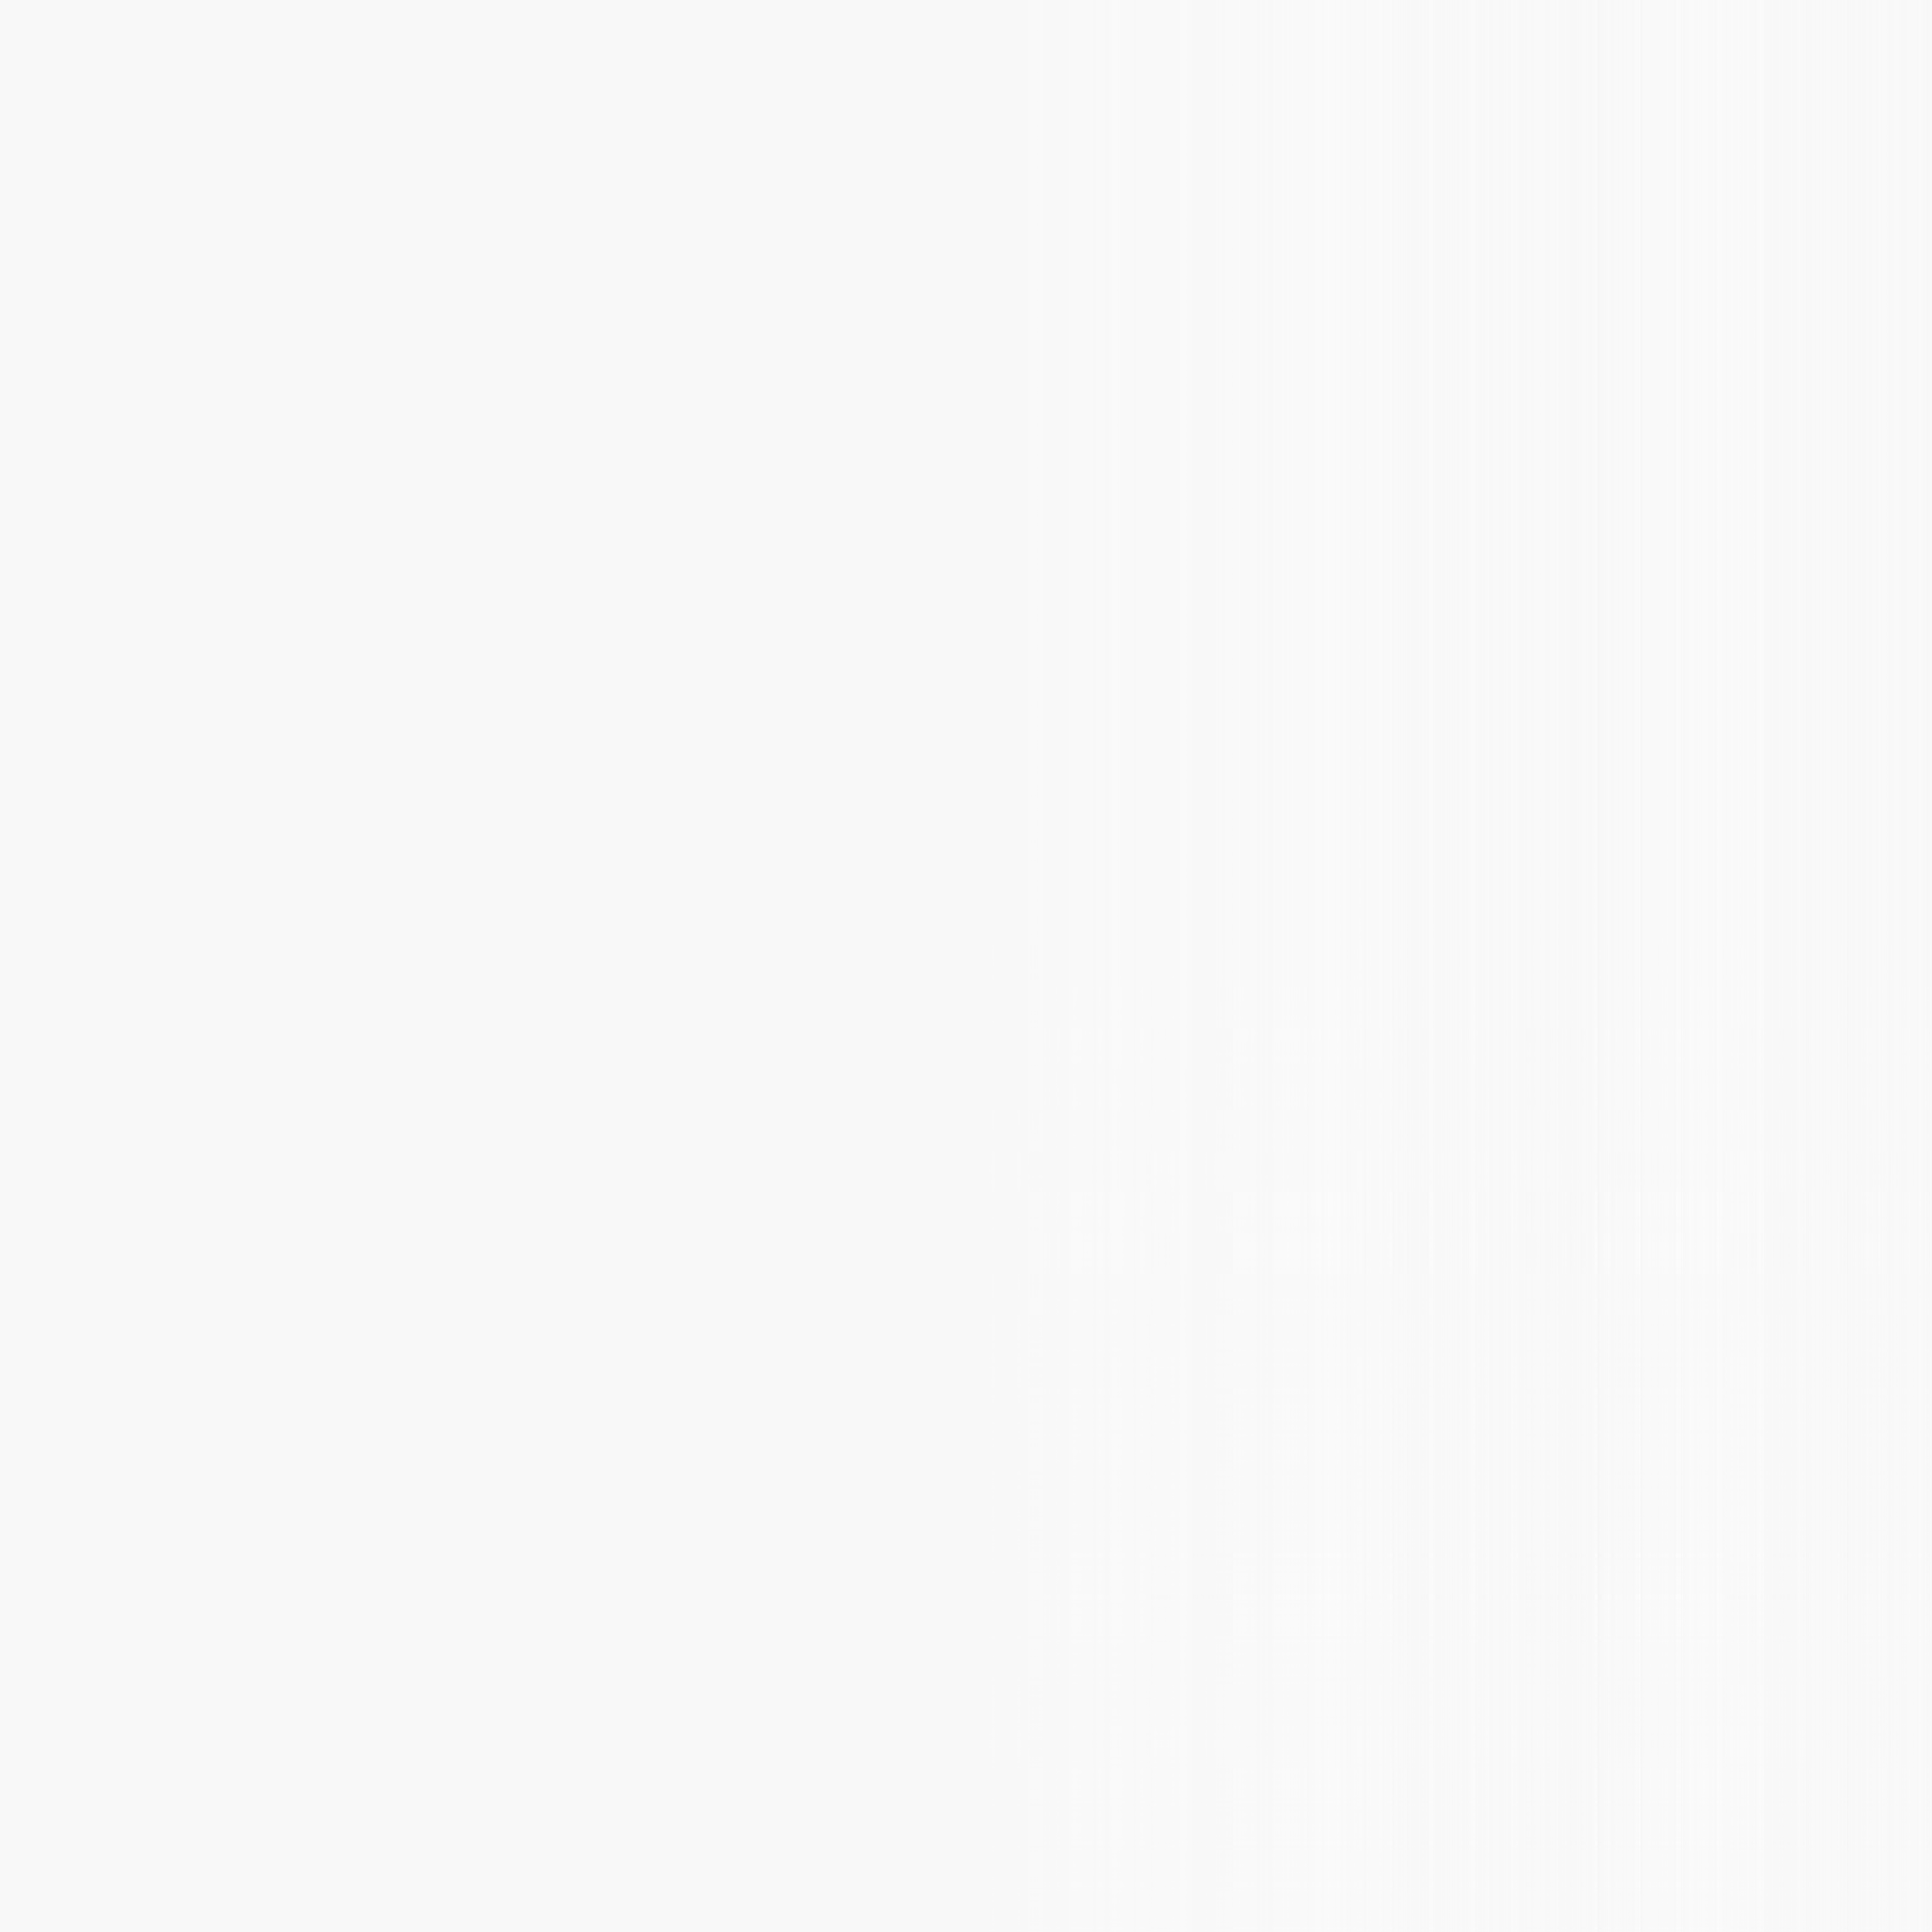

In [186]:
Image.fromarray(np.uint8(att[1].numpy()*255/np.max(att[1].numpy())))

In [16]:
# prepare to count predictions for each class
classes = {0: 'no_para', 1: 'para'}
correct_pred = {"para": 0, "no_para": 0}
total_pred = {"para": 0, "no_para": 0}
# correct_pred = {classname: 0 for classname in classes.values()}
# total_pred = {classname: 0 for classname in classes.values()}

# again no gradients needed
with torch.no_grad():
    for data in gpr_classification_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label.item() == prediction.item():
                correct_pred[classes[label.item()]] += 1
            total_pred[classes[label.item()]] += 1


# # print accuracy for each class
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [35]:
correct_pred

{'para': 5808, 'no_para': 5167}

In [36]:
total_pred

{'para': 6384, 'no_para': 6384}

In [209]:
predictions

tensor([0, 0])

In [37]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: para  is 91.0 %
Accuracy for class: no_para is 80.9 %


In [40]:
# torch.save(net.state_dict(), "models/gpr_classification_200-200_model.pt")